# Classifying webcam images

This example classifies images being shown to a webcam
using the ImageNet ILSVRC-2012 classifier.
To run it, please download the `ilsvrc2012-lif-48.pkl` file at
https://figshare.com/s/f343c68df647e675af28
and place it in the same directory as this example.

To install `pygobject` and other dependencies, we recommend

```
conda install -c conda-forge gst-plugins-base gst-plugins-good gstreamer pygobject
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

from nengo_extras.camera import Camera
from nengo_extras.data import load_ilsvrc2012_metadata, spasafe_names
from nengo_extras.cuda_convnet import CudaConvnetNetwork, load_model_pickle

In [2]:
data_mean, label_names = load_ilsvrc2012_metadata()
data_mean = data_mean[:, 16:-16, 16:-16]
image_shape = data_mean.shape

# retrieve from https://figshare.com/s/f343c68df647e675af28
cc_model = load_model_pickle("ilsvrc2012-lif-48.pkl")

In [3]:
# --- Run model in Nengo
with nengo.Network() as model:
    u = nengo.Node(
        Camera(
            device="/dev/video0",
            height=image_shape[1],
            width=image_shape[2],
            offset=-data_mean,
        )
    )
    u_probe = nengo.Probe(u, synapse=None)

    ccnet = CudaConvnetNetwork(cc_model, synapse=nengo.synapses.Alpha(0.001))
    nengo.Connection(u, ccnet.input, synapse=None)

    # --- output spa display
    vocab_names = spasafe_names(label_names)
    vocab_vectors = np.eye(len(vocab_names))

    vocab = nengo.spa.Vocabulary(len(vocab_names))
    for name, vector in zip(vocab_names, vocab_vectors):
        vocab.add(name, vector)

    config = nengo.Config(nengo.Ensemble)
    config[nengo.Ensemble].neuron_type = nengo.Direct()
    with config:
        output = nengo.spa.State(len(vocab_names), subdimensions=10, vocab=vocab)
    nengo.Connection(ccnet.output, output.input)

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(0.01)  # Get the first image

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

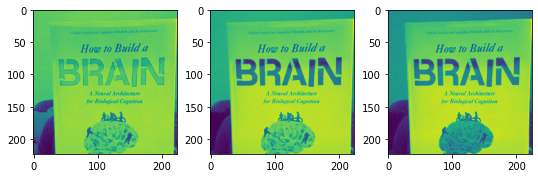

In [5]:
image = sim.data[u_probe][4].reshape(image_shape)
plt.figure(figsize=(9, 9))
for i, channel in enumerate(image):
    plt.subplot(3, 3, i + 1)
    plt.imshow(channel)